#WideResNetによる物体認識(Keras)

##本チュートリアルではkerasrを利用してニューラルネットワークの実装を確認，学習および評価を行います．　環境としてはGoogle が提供する Google Colaboratory上でおこないます． GPU上で処理を行うため，colaboratoryの[ランタイム]->[ランタイムのタイプを変更]からハードウェアアクセラレータをGPUにしてください．


Kerasではネットワークを構成する各層のコンポーネントが用意されています．ネットワーク構造を構築および学習するために必要なモジュールや関数をインポートします．

In [1]:
from keras.layers import Input, Conv2D, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Add, Activation, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


ここでは，10クラスの一般物体認識データセットCIFAR10を利用します．各画像サイズは32×32ピクセル，各クラス学習用に5000枚，評価用に1000枚の画像が用意されています．kerasではciar10というモジュールモジュールがあり，cifar10.load_data()によりデータのダウンロードができます．各画像の画素値が取りうる範囲は0から255までです．これらを0から1の範囲になるように255でわって正規化します．

In [2]:
from keras.datasets import cifar10
from keras.utils import to_categorical

# データの読み込み
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

170500096/170498071 [==============================] - 48s 0us/step


ネットワーク構造を構築を行います．まず，WideResNetのWideResidual Blockを用意します．ResidualBlockとの違いは，フィルタ数を一定数増やす倍率kが引数に増えています．そして，フィルタ数num_filterにkを乗じた値をConv2Dに与えています．

In [0]:
def WideResBlock(input, num_filters, k, kernel_size, stride, dropout_rate):
    out = Conv2D(filters=num_filters*k, kernel_size=kernel_size, strides = stride, padding='same')(input)
    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Conv2D(filters=num_filters*k, kernel_size=kernel_size, strides = (1,1), padding='same')(out)

    if dropout_rate > 0.0: out = Dropout(dropout_rate)(out)
        
    if stride[0] > 1 and stride[1] > 1 or input.shape[2] != num_filters:
        shortcut = Conv2D(filters=num_filters*k, kernel_size=(1, 1), strides = stride, padding="valid")(input)
    else:
        shortcut = input
    out = Add()([out, shortcut])
    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    return out

次に，ネットワーク全体の構成を用意します．１層目は畳み込み層とし，得られた特徴マップに対してバッチ正規化と活性化関数ReLUを施します．その後，WideResidualBlockが続きます．3つのWideResidualBlockを行った後，特徴マップを小さくするようにstrideを2とします．また，フィルタ数を２倍に増やします．最後にGlobal Average Poolingを行い，出力層にて１０クラスの各クラスの確率を出力します．各WideResidualBlockに与えるフィルタ数の倍数kは8としています．

In [0]:
k = 8

input_ = Input(shape=(32, 32, 3))

c = Conv2D(16, (3, 3), strides=(1,1), padding="same")(input_)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = WideResBlock(c,num_filters=16, k= k, kernel_size=(3, 3), stride=(2,2), dropout_rate = 0.0)
c = WideResBlock(c,num_filters=16, k= k, kernel_size=(3, 3), stride=(1,1),  dropout_rate = 0.0)
c = WideResBlock(c,num_filters=16, k= k, kernel_size=(3, 3), stride=(1,1),  dropout_rate = 0.0)

c = WideResBlock(c,num_filters=32, k=k, kernel_size=(3, 3), stride=(2,2), dropout_rate = 0.0)
c = WideResBlock(c,num_filters=32, k=k, kernel_size=(3, 3), stride=(1,1), dropout_rate = 0.0)
c = WideResBlock(c,num_filters=32, k=k, kernel_size=(3, 3), stride=(1,1), dropout_rate = 0.0)

c = WideResBlock(c,num_filters=64, k=k, kernel_size=(3, 3), stride=(2,2), dropout_rate = 0.0)
c = WideResBlock(c,num_filters=64, k=k, kernel_size=(3, 3), stride=(1,1), dropout_rate = 0.0)
c = WideResBlock(c,num_filters=64, k=k, kernel_size=(3, 3), stride=(1,1), dropout_rate = 0.0)

c = GlobalAveragePooling2D()(c)
c = Dense(10, activation='softmax')(c)

構築したネットワークをmodelとし，compileにより学習できるようにします．

In [0]:
model = Model(input_, c)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(amsgrad=False),
              metrics=['accuracy'])

data augmentationを行うdatagenを用意します．ImageDataGeneratorは，各種data augmentation方法のパラメータを指定すると学習時にこれらの変形を適宜適用してくれます．

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

data augmentationを行う，datagenに学習データX_trainを与えます．
そして，model.fit_generatorにより学習を行います．学習におけるミニバッチサイズを128，学習エポック数を100とします．
また，X_test, y_testを検証用データセットとして与えます．

In [26]:
from keras.callbacks import CSVLogger

log_name = "log_wideresnet168.csv"
datagen.fit(X_train)

csv_logger = CSVLogger(log_name, append=True, separator=';')

logs = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                        steps_per_epoch=X_train.shape[0] // 128,
                        validation_data=(X_test, y_test),
                        epochs=100, verbose=1, callbacks=[csv_logger])



Epoch 1/100
390/390 [==============================] - 138s 355ms/step - loss: 1.6726 - acc: 0.3791 - val_loss: 2.2096 - val_acc: 0.4143
Epoch 2/100
390/390 [==============================] - 130s 333ms/step - loss: 1.2824 - acc: 0.5396 - val_loss: 2.2142 - val_acc: 0.4614
Epoch 3/100
390/390 [==============================] - 130s 333ms/step - loss: 1.0692 - acc: 0.6214 - val_loss: 1.4248 - val_acc: 0.5735
Epoch 4/100
390/390 [==============================] - 130s 332ms/step - loss: 0.9154 - acc: 0.6819 - val_loss: 1.5750 - val_acc: 0.5477
Epoch 5/100
390/390 [==============================] - 129s 332ms/step - loss: 0.8025 - acc: 0.7231 - val_loss: 1.0074 - val_acc: 0.6755
Epoch 6/100
390/390 [==============================] - 130s 333ms/step - loss: 0.7292 - acc: 0.7495 - val_loss: 1.6733 - val_acc: 0.5821
Epoch 7/100
390/390 [==============================] - 130s 333ms/step - loss: 0.6559 - acc: 0.7752 - val_loss: 0.7557 - val_acc: 0.7613
Epoch 8/100
390/390 [====================

学習時のロスと精度のログをダウンロードします．

In [0]:
from google.colab import files
files.download(log_name)

学習データおよび評価データに対するロスと精度のグラフを表示します．

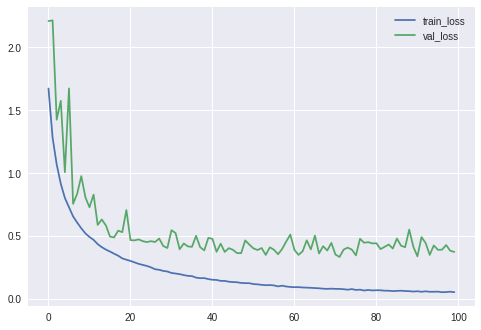

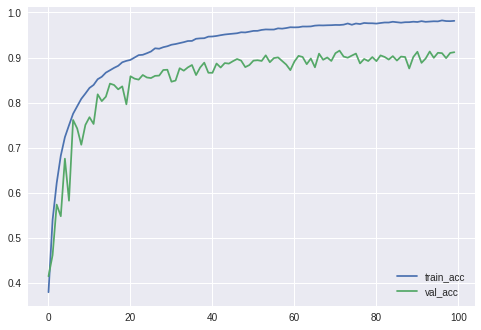

In [28]:
plt.figure()               
plt.plot(logs.history['loss'],label="train_loss")
plt.plot(logs.history['val_loss'],label="val_loss")
plt.legend()
plt.show()

plt.figure()               
plt.plot(logs.history['acc'],label="train_acc")
plt.plot(logs.history['val_acc'],label="val_acc")
plt.legend(loc="lower right")
plt.show()

# 課題

１．学習エポック数を増やして精度が向上するか確認しましょう

２．ネットワーク構造を変えましょう．ResidualBlockの数を１８層から増やすまたは，減らした場合の精度を比較しましょう

２．Data augmentation方法を変えましょう．ImageDataGeneratorで指定する範囲や内容を変えて精度を比較しましょう



In [0]:
input_ = Input(shape=(32, 32, 3))

c = Conv2D(64, (1, 1), padding="same")(input_)
c = Activation("relu")(c)
c = Conv2D(64, (3, 3), padding="same")(c)
c = Activation("relu")(c)
c = Conv2D(64, (3, 3), padding="same")(c)
c = Activation("relu")(c)
c = Conv2D(64, (3, 3), strides=2)(c)
c = Activation("relu")(c)

c = Conv2D(128, (3, 3), padding="same")(c)
c = Activation("relu")(c)
c = Conv2D(128, (3, 3), padding="same")(c)
c = Activation("relu")(c)
c = Conv2D(128, (3, 3), strides=2)(c)
c = Activation("relu")(c)

c = Conv2D(256, (3, 3), padding="same")(c)
c = Activation("relu")(c)
c = Conv2D(256, (3, 3), padding="same")(c)
c = Activation("relu")(c)
c = Conv2D(256, (3, 3), strides=2)(c)
c = Activation("relu")(c)

c = Flatten()(c)
c = Dense(10, activation='softmax')(c)

In [0]:
input_ = Input(shape=(32, 32, 3))

c = Conv2D(64, (1, 1), padding="same")(input_)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = ResBlock(c,num_filters=64, kernel_size=(3, 3), stride=(1,1))
c = Conv2D(64, (3, 3), strides=2)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = ResBlock(c,num_filters=64, kernel_size=(3, 3), stride=(1,1))
c = Conv2D(128, (3, 3), strides=2)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = ResBlock(c,num_filters=128, kernel_size=(3, 3), stride=(1,1))
c = Conv2D(256, (3, 3), strides=2)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)

c = GlobalAveragePooling2D()(c)
c = Dense(10, activation='softmax')(c)

In [0]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
